<a href="https://colab.research.google.com/github/spirosChv/neuro208/blob/main/synapse_NEURON/synapse_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuron --quiet

     |████████████████████████████████| 15.0 MB 310 kB/s 


In [2]:
# @title Create the mod file `ampa_nmda.mod`
# @markdown Execute this cell.
with open("ampa_nmda.mod", "w") as file:
  file.write("""
  
    TITLE Excitatory Synapse with AMPA/NMDA components

    COMMENT
    AMPA/NMDA currents: are based on double exponentials of a decay and a rise phase, with a scaling factor
      gampa, gnmda: opening/closing states in [0,1]
      tau1: rise, tau2: decay

    w_ampa/w_nmda: the relevant weights. gampa_max and gnmda_max can be omitted in a later version of the file

    A portion of inmda is updating the ica (calcium current)

    Authors: S. Chavlis, PhD (schavlis AT imbb.forth.gr)
    ENDCOMMENT

    NEURON {
      POINT_PROCESS AmpaNmda
      NONSPECIFIC_CURRENT isyn
      USEION ca WRITE ica
      RANGE tau1_ampa, tau2_ampa, eampa, w_ampa, gampa, gbar_ampa, iampa
      RANGE tau1_nmda, tau2_nmda, enmda, w_nmda, gnmda, gbar_nmda, inmda
      RANGE fca
    }

    UNITS {
      (uS) = (microsiemens)
      (nA) = (nanoamp)
      (mV) = (millivolt)
      (molar) = (1/liter)
      (mM) = (millimolar)
    }

    PARAMETER {
      : AMPA parameters
      tau1_ampa = 1.0 (ms) : rise time constant AMPA
      tau2_ampa = 10.0 (ms) : decay time constant AMPA
      eampa = 0 (mV) : reversal potential AMPA
      w_ampa = 1 (1) : strength of the synapse AMPA
      gbar_ampa = 0 (uS) : maximum conductance AMPA
      
      : NMDA parameters
      tau1_nmda = 2.3 (ms) : rise time constant AMPA
      tau2_nmda = 95.0 (ms) : decay time constant AMPA
      enmda = 0 (mV) : reversal potential AMPA
      w_nmda = 1 (1) : strength of the synapse AMPA
      gbar_nmda = 0 (uS) : maximum conductance AMPA

      : Magnesium blockage of NMDA parameters
      gamma_mg = 0.0625 (/mV) : Magnesium Concentration factor
      eta_mg = 0.28011 (/mM) : Magnesium sensitivity of unblock, 1/3.57
      mg2o = 1.2 (mM) : extracellular magnesium concentration

      fca = 0.1 (1) : portion of inmda that is accumulated into ica
    }

    ASSIGNED {
      v (mV) : membrane voltage
      ica (nA) : total calcium current
      isyn (nA) : synaptic current that changes the membrane voltage

      gampa (1) : gating of AMPARs
      iampa (nA) : AMPA current

      gnmda (1) : gating of NMDARs
      inmda (nA) : NMDA current
    }

    STATE {
      A_ampa (1) : rise of AMPA
      B_ampa (1) : decay of AMPA
      A_nmda (1) : rise of NMDA
      B_nmda (1) : decay of NMDA
    }

    BREAKPOINT {
      SOLVE states METHOD cnexp
      gampa = B_ampa - A_ampa
      iampa = gbar_ampa*gampa*(v - eampa) : uS*mV=nA
      
      gnmda = B_nmda - A_nmda
      inmda = gbar_nmda*gnmda*(v - enmda)*mgblock(v, gamma_mg, eta_mg, mg2o) : uS*mV=nA

      isyn = iampa + inmda*(1-fca) : total synaptic current to update the membrane voltage
      ica =  fca*inmda : ica current from the NMDA synapse
    }

    DERIVATIVE states {
      A_ampa' = -A_ampa/tau1_ampa
      B_ampa' = -B_ampa/tau2_ampa

      A_nmda' = -A_nmda/tau1_nmda
      B_nmda' = -B_nmda/tau2_nmda
    }

    INITIAL {
      : Check the time constants for AMPA and NMDA
      if (tau1_ampa/tau2_ampa > .9999) {
        tau1_ampa = .9999*tau2_ampa
      }
      if (tau1_ampa/tau2_ampa < 1e-9) {
        tau1_ampa = tau2_ampa*1e-9
      }

      if (tau1_nmda/tau2_nmda > .9999) {
        tau1_nmda = .9999*tau2_nmda
      }
      if (tau1_nmda/tau2_nmda < 1e-9) {
        tau1_nmda = tau2_nmda*1e-9
      }

      : set all values at zero in the start
      A_ampa = 0
      B_ampa = 0

      A_nmda = 0
      B_nmda = 0
    }

    FUNCTION factor(tau1 (ms), tau2 (ms)) {
      LOCAL tpeak, peak
      tpeak = (tau1*tau2)/(tau2 - tau1) * log(tau2/tau1) : time of peak
      peak = exp(-tpeak/tau2) - exp(-tpeak/tau1) : peak conductance
      factor = 1/peak
    }

    FUNCTION mgblock(v (mV), gamma (/mV), eta (/mM), mgo (mM)) {
      mgblock = 1/(1 + eta*mgo*exp(-gamma*v))
    }

    NET_RECEIVE(weight) {

      INITIAL {
        weight = 1
      }
      : At every pre-synaptic spike update A (rise) and B (decay) phases
      : of AMPA and NMDA
      A_ampa = A_ampa + w_ampa*factor(tau1_ampa, tau2_ampa)*weight
      B_ampa = B_ampa + w_ampa*factor(tau1_ampa, tau2_ampa)*weight

      A_nmda = A_nmda + w_nmda*factor(tau1_nmda, tau2_nmda)*weight
      B_nmda = B_nmda + w_nmda*factor(tau1_nmda, tau2_nmda)*weight
    }
  """)

In [3]:
# @title Create the mod file `ampa_nmda_plasticity.mod`
# @markdown Execute this cell.
with open("ampa_nmda_plasticity.mod", "w") as file:
  file.write("""

    TITLE Excitatory Synapse with AMPA/NMDA components and Short-Term Plasticity

    COMMENT
    AMPA/NMDA currents: are based on double exponentials of a decay and a rise phase, with a scaling factor
      gampa, gnmda: opening/closing states in [0,1]
      tau1: rise, tau2: decay

    w_ampa/w_nmda: the relevant weights. gbar_ampa and gbar_nmda can be omitted in a later version of the file

    A portion of `inmda` is updating the `ica` (calcium current)

    Authors: S. Chavlis, PhD (schavlis AT imbb.forth.gr)
    ENDCOMMENT

    NEURON {
      POINT_PROCESS AmpaNmdaP
      NONSPECIFIC_CURRENT isyn
      USEION ca WRITE ica
      RANGE tau1_ampa, tau2_ampa, eampa, w_ampa, gampa, gbar_ampa, iampa
      RANGE tau1_nmda, tau2_nmda, enmda, w_nmda, gnmda, gbar_nmda, inmda
      RANGE tauD, tauF, U0, r, u
      RANGE fca
    }

    UNITS {
      (uS) = (microsiemens)
      (nA) = (nanoamp)
      (mV) = (millivolt)
      (molar) = (1/liter)
      (mM) = (millimolar)
    }

    PARAMETER {
      : AMPA parameters
      tau1_ampa = 1.0 (ms) : rise time constant AMPA
      tau2_ampa = 10.0 (ms) : decay time constant AMPA
      eampa = 0 (mV) : reversal potential AMPA
      w_ampa = 1 (1) : strength of the synapse AMPA
      gbar_ampa = 0 (uS) : maximum conductance AMPA
      
      : NMDA parameters
      tau1_nmda = 2.3 (ms) : rise time constant AMPA
      tau2_nmda = 95.0 (ms) : decay time constant AMPA
      enmda = 0 (mV) : reversal potential AMPA
      w_nmda = 1 (1) : strength of the synapse AMPA
      gbar_nmda = 0 (uS) : maximum conductance AMPA

      : Magnesium blockage of NMDA parameters
      gamma_mg = 0.0625 (/mV) : Magnesium Concentration factor
      eta_mg = 0.28011 (/mM) : Magnesium sensitivity of unblock, 1/3.57
      mg2o = 1.2 (mM) : extracellular magnesium concentration

      fca = 0.1 (1) : portion of inmda that is accumulated into ica

      : Short-term dynamics (Tsodkys, Markham model)
        tauD = 800 (ms)  : Depression time constant
        tauF = 800 (ms)  : Facilitation time constant
        U0 = .3  (1)   : initial `concentration` of vesicles
    }

    ASSIGNED {
      v (mV) : membrane voltage
      ica (nA) : total calcium current
      isyn (nA) : synaptic current that changes the membrane voltage

      gampa (1) : gating of AMPARs
      iampa (nA) : AMPA current

      gnmda (1) : gating of NMDARs
      inmda (nA) : NMDA current
    }

    STATE {
      A_ampa (1) : rise of AMPA
      B_ampa (1) : decay of AMPA
      A_nmda (1) : rise of NMDA
      B_nmda (1) : decay of NMDA
      r (1) : resources available
      u (1) : release probability
    }

    BREAKPOINT {
      SOLVE states METHOD cnexp
      gampa = B_ampa - A_ampa
      iampa = gbar_ampa*gampa*(v - eampa) : uS*mV=nA
      
      gnmda = B_nmda - A_nmda
      inmda = gbar_nmda*gnmda*(v - enmda)*mgblock(v, gamma_mg, eta_mg, mg2o) : uS*mV=nA

      isyn = iampa + inmda*(1-fca) : total synaptic current to update the membrane voltage
      ica =  fca*inmda : ica current from the NMDA synapse
    }

    DERIVATIVE states {
      A_ampa' = -A_ampa/tau1_ampa
      B_ampa' = -B_ampa/tau2_ampa

      A_nmda' = -A_nmda/tau1_nmda
      B_nmda' = -B_nmda/tau2_nmda

      r' = (1.0-r)/tauD
      u' = -u/tauF
    }

    INITIAL {
      : Check the time constants for AMPA and NMDA
      if (tau1_ampa/tau2_ampa > .9999) {
        tau1_ampa = .9999*tau2_ampa
      }
      if (tau1_ampa/tau2_ampa < 1e-9) {
        tau1_ampa = tau2_ampa*1e-9
      }

      if (tau1_nmda/tau2_nmda > .9999) {
        tau1_nmda = .9999*tau2_nmda
      }
      if (tau1_nmda/tau2_nmda < 1e-9) {
        tau1_nmda = tau2_nmda*1e-9
      }

      : set all values at zero in the start
      A_ampa = 0
      B_ampa = 0

      A_nmda = 0
      B_nmda = 0
      u = U0
      r = 1.0
    }

    FUNCTION factor(tau1 (ms), tau2 (ms)) {
      LOCAL tpeak, peak
      tpeak = (tau1*tau2)/(tau2 - tau1) * log(tau2/tau1) : time of peak
      peak = exp(-tpeak/tau2) - exp(-tpeak/tau1) : peak conductance
      factor = 1/peak
    }

    FUNCTION mgblock(v (mV), gamma (/mV), eta (/mM), mgo (mM)) {
      mgblock = 1/(1 + eta*mgo*exp(-gamma*v))
    }

    NET_RECEIVE(weight) {
      LOCAL r_minus, x_val

      INITIAL {
        weight = 1
      }

      :Calculate the u and R variables at each presynaptic spike

      u = u + U0*(1.0 - u)
      r_minus = r
      r = r + (-u*r)
      
      : At every pre-synaptic spike update A (rise) and B (decay) phases
      : of AMPA and NMDA
      x_val = w_ampa*weight*factor(tau1_ampa, tau2_ampa)*r_minus*u
      A_ampa = A_ampa + x_val
      B_ampa = B_ampa + x_val
        
        x_val = w_nmda*weight*factor(tau1_nmda, tau2_nmda)*r_minus*u
      A_nmda = A_nmda + x_val
      B_nmda = B_nmda + x_val
    }
  """)

In [4]:
# @title Create the mod file `vecstim.mod`
# @markdown Execute this cell.
with open("vecstim.mod", "w") as file:
  file.write("""

    TITLE Vector stream of events

    NEURON {
      THREADSAFE
      ARTIFICIAL_CELL VecStim
      RANGE delay
    }

    ASSIGNED {
      index
      etime (ms)
      space
      delay (ms)
    }

    PARAMETER { 
      ::delay = 0.0
    } 

    INITIAL {
      index = 0
      : delay = 0
      element()
      if (index > 0) {
        net_send(delay + etime - t, 1)
      }
    }

    NET_RECEIVE (w) {
      if (flag == 1) {
        net_event(t)
        element()
        if (index > 0) {
          net_send(delay + etime - t, 1)
        }
      }
    }

    VERBATIM
    extern double* vector_vec();
    extern int vector_capacity();
    extern void* vector_arg();
    ENDVERBATIM

    PROCEDURE element() {
    VERBATIM	
    { void* vv; int i, size; double* px;
      i = (int)index;
      if (i >= 0) {
        vv = *((void**)(&space));
        if (vv) {
          size = vector_capacity(vv);
          px = vector_vec(vv);
          if (i < size) {
            etime = px[i];
            index += 1.;
          }else{
            index = -1.;
          }
        }else{
          index = -1.;
        }
      }
    }
    ENDVERBATIM
    }

    PROCEDURE play() {
    VERBATIM
      void** vv;
      vv = (void**)(&space);
      *vv = (void*)0;
      if (ifarg(1)) {
        *vv = vector_arg(1);
      }
    ENDVERBATIM
    }
  """)

In [5]:
!rm -rf x86_64/
!nrnivmodl

/content
Mod files: "./ampa_nmda.mod" "./ampa_nmda_plasticity.mod" "./vecstim.mod"

Creating x86_64 directory for .o files.

COBJS=''
 -> Compiling mod_func.cpp
 -> NMODL ../ampa_nmda_plasticity.mod
 -> NMODL ../vecstim.mod
 -> NMODL ../ampa_nmda.mod
Translating ampa_nmda_plasticity.mod into /content/x86_64/ampa_nmda_plasticity.c
Translating ampa_nmda.mod into /content/x86_64/ampa_nmda.c
Thread Safe
Thread Safe
Translating vecstim.mod into /content/x86_64/vecstim.c
 -> Compiling ampa_nmda.c
Thread Safe
 -> Compiling ampa_nmda_plasticity.c
 -> Compiling vecstim.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special


In [6]:
from neuron import h
from neuron.units import ms, mV
import matplotlib.pyplot as plt
h.load_file("stdrun.hoc")

1.0

In [7]:
# @title Make nicer plots -- Execute this cell
def mystyle():
  """
  Create custom plotting style.

  Returns
  -------
  my_style : dict
      Dictionary with matplotlib parameters.

  """
  # color pallette
  style = {
      # Use LaTeX to write all text
      "text.usetex": False,
      "font.family": "DejaVu Sans",
      "font.weight": "bold",
      # Use 16pt font in plots, to match 16pt font in document
      "axes.labelsize": 16,
      "axes.titlesize": 20,
      "font.size": 16,
      # Make the legend/label fonts a little smaller
      "legend.fontsize": 14,
      "xtick.labelsize": 14,
      "ytick.labelsize": 14,
      "axes.linewidth": 2.5,
      "lines.markersize": 10.0,
      "lines.linewidth": 2.5,
      "xtick.major.width": 2.2,
      "ytick.major.width": 2.2,
      "axes.labelweight": "bold",
      "axes.spines.right": False,
      "axes.spines.top": False
  }

  return style


plt.style.use("seaborn-colorblind")
plt.rcParams.update(mystyle())

In [8]:
# Create the cable1
dend1 = h.Section(name='dend1')
dend1.L = 100
dend1.diam = 2
dend1.nseg = 11
dend1.insert('pas')

# Create the cable1
dend2 = h.Section(name='dend2')
dend2.L = 100
dend2.diam = 2
dend2.nseg = 11
dend2.insert('pas')

dend2

In [9]:
# Define the presynaptic spike train
pre_spikes = [100, 150, 200, 250, 300, 350]  # list with presynaptic spikes (ms)
inputs = h.Vector(pre_spikes)
# inputs = h.Vector([100])

# VecStim
vecstim = h.VecStim()
vecstim.play(inputs)

# Synapse - plastic
syn1 = h.AmpaNmdaP(dend1(0.5))
syn1.eampa = 0
syn1.tau1_ampa = 2
syn1.tau2_ampa = 10
syn1.gbar_ampa = .001

syn1.enmda = 0
syn1.tau1_nmda = 8
syn1.tau2_nmda = 100
syn1.gbar_nmda = .001

# parameters of STP -- Depression
stp = 'facilitation'
if stp == 'depression':
  syn1.U0 = .5
  syn1.tauD = 100
  syn1.tauF = 50
elif stp == 'facilitation':
  syn1.U0 = .2
  syn1.tauD = 100
  syn1.tauF = 750


# NetCon - plastic
vs1 = h.NetCon(vecstim, syn1)
vs1.delay = 1.0  # delay in ms
vs1.weight[0] = 1

# Synapse - non-plastic
syn2 = h.AmpaNmda(dend2(0.5))
syn2.eampa = 0
syn2.tau1_ampa = 2
syn2.tau2_ampa = 10
syn2.gbar_ampa = .001

syn2.enmda = 0
syn2.tau1_nmda = 8
syn2.tau2_nmda = 50
syn2.gbar_nmda = .001

# NetCon - non-plastic
vs2 = h.NetCon(vecstim, syn2)
vs2.delay = 1.0  # delay in ms
vs2.weight[0] = 1

In [10]:
# Record vectors
v_vec1 = h.Vector().record(dend1(0.5)._ref_v)
v_vec2 = h.Vector().record(dend2(0.5)._ref_v)
t_vec = h.Vector().record(h._ref_t)

r_vec = h.Vector().record(syn1._ref_r)
u_vec = h.Vector().record(syn1._ref_u)

In [11]:
# Run simulation
h.finitialize(-70 * mV)
h.continuerun(1000 * ms)

0.0

In [12]:
# Normalization in [0, 1]
v_vec1_norm = (v_vec1 - v_vec1.min())/(v_vec1.max() - v_vec1.min())
v_vec2_norm = (v_vec2 - v_vec2.min())/(v_vec2.max() - v_vec2.min())

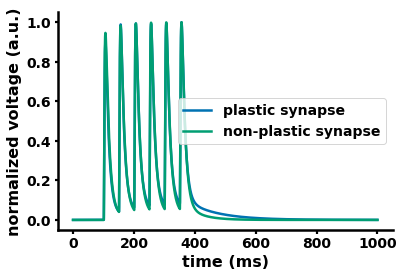

In [13]:
# Plot the results
plt.figure()
plt.plot(t_vec, v_vec1_norm, label='plastic synapse')
plt.plot(t_vec, v_vec2_norm, label='non-plastic synapse')
plt.xlabel('time (ms)')
plt.ylabel('normalized voltage (a.u.)')
plt.legend()
plt.show()

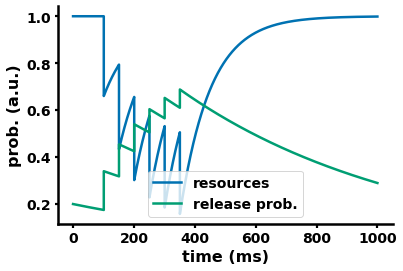

In [14]:
# Plot the results
plt.figure()
plt.plot(t_vec, r_vec, label='resources')
plt.plot(t_vec, u_vec, label='release prob.')
plt.xlabel('time (ms)')
plt.ylabel('prob. (a.u.)')
plt.legend()
plt.show()